In [1]:
# Read the CSV file as a sparse matrix
# File path: /mnt/volume1/qyc/data/Inter-dataset/PbmcBench/CEL-Seq/CL_pbmc1.csv
# Format: genes as columns, cells as rows
import pandas as pd
import scipy.sparse as sp

# Read the CSV file
df = pd.read_csv('/mnt/volume1/qyc/data/Intra-dataset/AMB/Filtered_mouse_allen_brain_data.csv', index_col=0)

In [20]:
# Convert to sparse matrix
sparse_matrix = sp.csr_matrix(df.values)

In [30]:
true_label = pd.read_csv("/mnt/volume1/qyc/data/Intra-dataset/AMB/Labels.csv")
pred_label = pd.read_csv("/mnt/volume1/qyc/auto-annot/results/scVI/Filtered_mouse_allen_brain_data/scVI_Pred_Labels.csv")

In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [35]:
# 设置scanpy参数
sc.settings.set_figure_params(dpi=100, frameon=False)
sc.settings.verbosity = 3

# 创建AnnData对象
adata = sc.AnnData(sparse_matrix)[6:]

In [36]:
# 添加标签信息
adata.obs['true_label'] = true_label[:-6].values.flatten()
adata.obs['pred_label'] = pred_label.values.flatten()

/tmp/ipykernel_2756837/1732929530.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['true_label'] = true_label[:-6].values.flatten()


In [38]:
# 预处理
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

filtered out 2380 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/srtp/anaconda3/envs/bidcell/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [24]:
# 降维
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 40


2025-05-25 16:03:52.141555: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-25 16:03:52.594182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [25]:
# 聚类
sc.tl.leiden(adata, resolution=0.8)
adata.obs['cluster'] = adata.obs['leiden']

running Leiden clustering


/tmp/ipykernel_2756837/2145802487.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.8)


    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

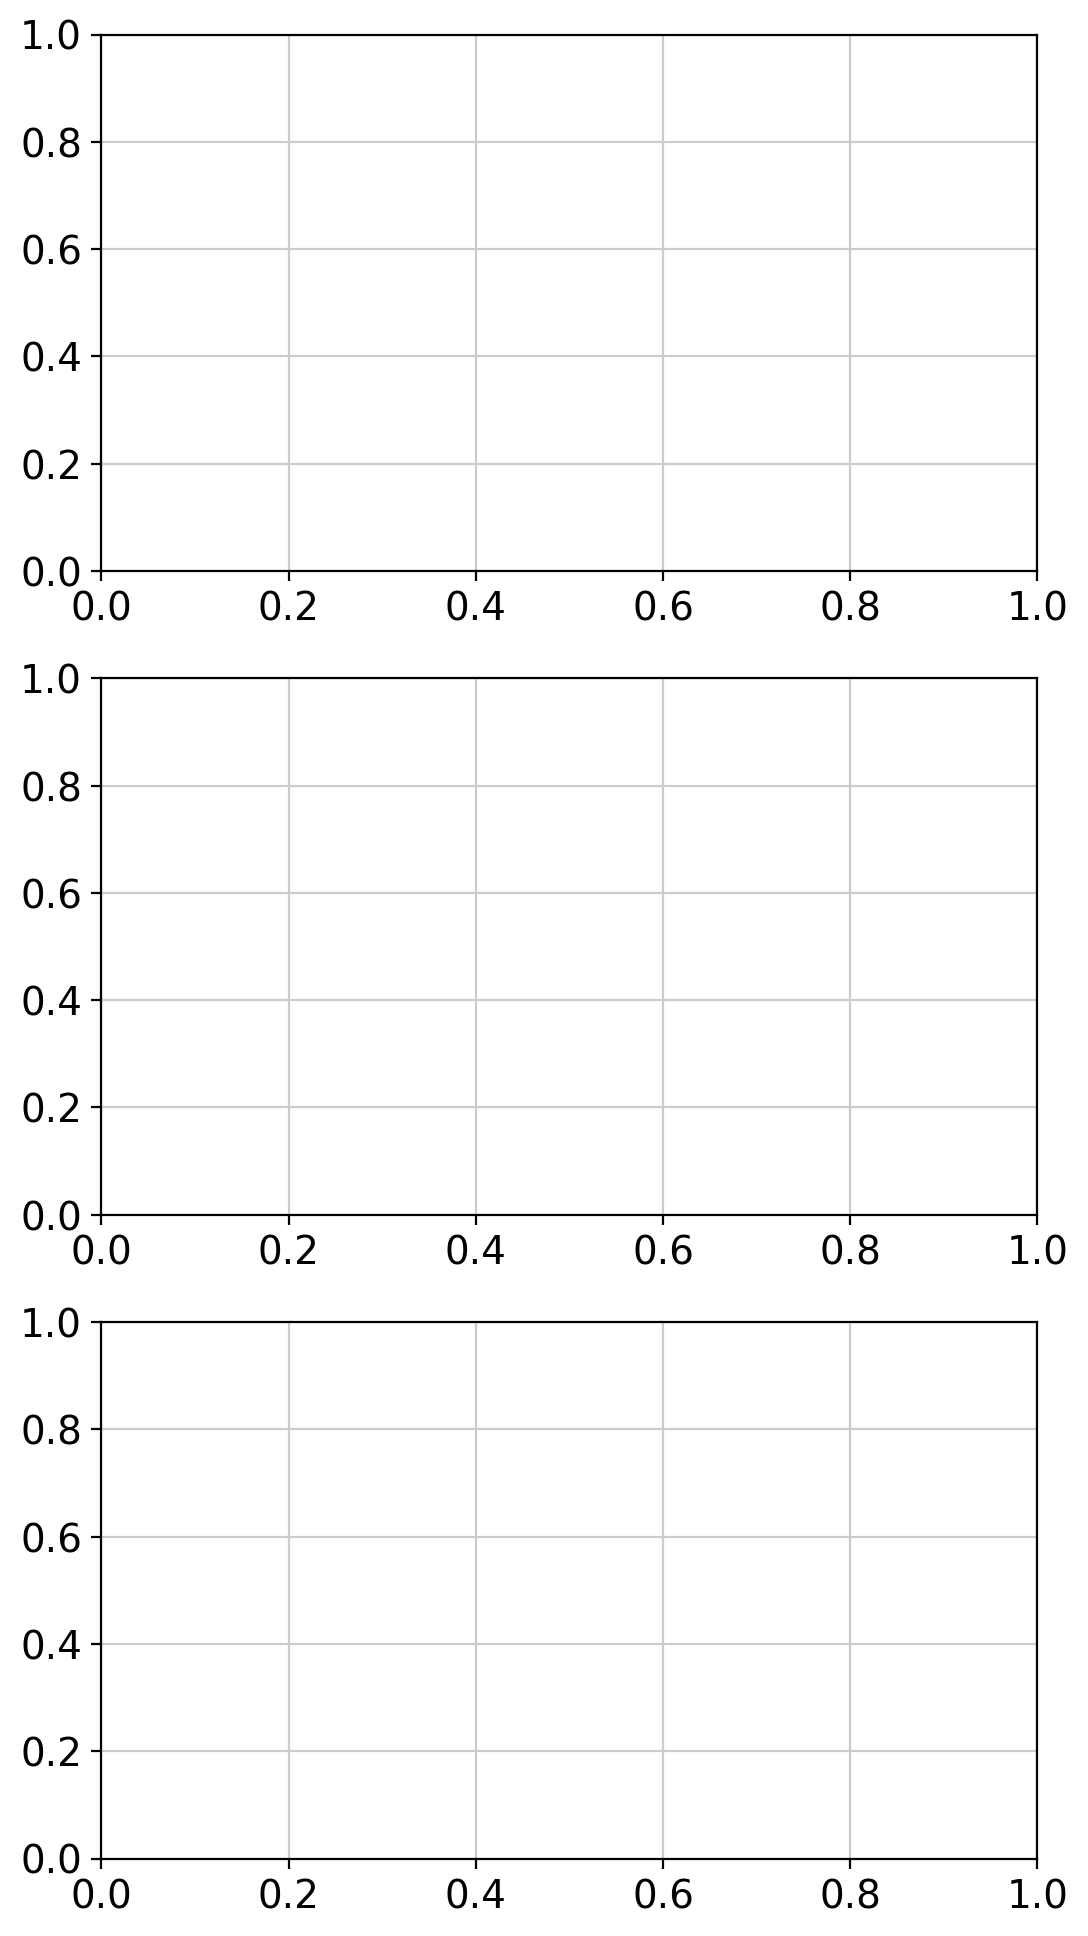

In [37]:
# 创建图形
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 12))

# 绘制真实标签的UMAP
sc.pl.umap(adata, color='true_label', ax=ax1, show=False, title='True Labels')
ax1.set_title('True Labels', pad=20)

# 绘制预测标签的UMAP
sc.pl.umap(adata, color='pred_label', ax=ax2, show=False, title='Predicted Labels')
ax2.set_title('Predicted Labels', pad=20)

# 绘制聚类结果的UMAP
sc.pl.umap(adata, color='cluster', ax=ax3, show=False, title='Clusters')
ax3.set_title('Clusters', pad=20)

# 调整布局
plt.tight_layout()

# 分别保存三张图
# 真实标签
plt.figure(figsize=(6, 6))
sc.pl.umap(adata, color='true_label', show=False, title='True Labels')
plt.savefig('umap_true_labels1.pdf', bbox_inches='tight')
plt.close()

# 预测标签
plt.figure(figsize=(6, 6))
sc.pl.umap(adata, color='pred_label', show=False, title='Predicted Labels')
plt.savefig('umap_pred_labels1.pdf', bbox_inches='tight')
plt.close()

# 聚类结果
plt.figure(figsize=(6, 6))
sc.pl.umap(adata, color='cluster', show=False, title='Clusters')
plt.savefig('umap_clusters1.pdf', bbox_inches='tight')
plt.close()